In [61]:
import numpy as np
import pandas as pd
import cv2
import os
import ast
import shutil
from skimage import io, draw
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import albumentations as albu
from albumentations import Compose
from google.colab.patches import cv2_imshow

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
import torch
from IPython.core.display import clear_output

In [64]:
!pwd

/content/drive/My Drive/PROJECT_PADHAI/yolov5


In [100]:
%cd /content/drive/MyDrive/PROJECT_PADHAI

/content/drive/MyDrive/PROJECT_PADHAI


In [101]:
!pwd

/content/drive/MyDrive/PROJECT_PADHAI


In [102]:
!ls

Computer_Vision  recognition


In [103]:
!git clone https://github.com/ultralytics/yolov5.git
os.chdir('./yolov5')
%pip install -qr requirements.txt --use-deprecated=legacy-resolver

Cloning into 'yolov5'...
remote: Enumerating objects: 16954, done.
remote: Counting objects: 100% (149/149), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 16954 (delta 76), reused 96 (delta 46), pack-reused 16805 (from 1)
Receiving objects: 100% (16954/16954), 15.70 MiB | 15.15 MiB/s, done.
Resolving deltas: 100% (11605/11605), done.


In [68]:
image_folder = '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image'
files=os.listdir(image_folder)
paths=[]
for i in files:
    paths.append(os.path.join(image_folder,i))

paths[:5]

['/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/42.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/276.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/231.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/268.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/307.jpg']

In [69]:
import glob
paths=glob.glob('/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/*')
paths[:5]

['/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/42.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/276.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/231.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/268.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/307.jpg']

In [70]:
image_folder = '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image'
image_path = [os.path.join(image_folder, name) for name in os.listdir(image_folder)]
annotation_path = '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Annotation'
annotations = pd.DataFrame(columns = ['img_path','img_height','img_width','box','coordinates','height','width','xy_center','language'])

data = {}

In [71]:
image_path[:5]

['/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/42.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/276.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/231.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/268.jpg',
 '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/307.jpg']

In [72]:
annotations

,img_path,img_height,img_width,box,coordinates,height,width,xy_center,language


Function to allign all corner coordinates such that rectangular bounding box will be produced

In [73]:
def correct_coordinates(coord):
    x1,x2,x3,x4,y1,y2,y3,y4 = coord[0],coord[1],coord[2],coord[3],coord[4],coord[5],coord[6],coord[7]
    x1 = x4 = min(x1,x4)
    x2 = x3 = max(x2,x3)
    y1 = y2 = min(y1,y2)
    y3 = y4 = max(y3,y4)
    return(x1,x2,x3,x4,y1,y2,y3,y4)


Function to calculate bounding box features

In [74]:
def box_features(file_path):
    with open(file_path,'r') as annot:
        box = []
        for num in annot.readlines():
            temp = {}
            coord = num.split(',')[:8]
            coord = correct_coordinates([int(i) for i in coord])
            temp['coord'] = coord
            temp['height'] = abs(coord[7] - coord[4])
            temp['width'] = abs(coord[1] - coord[0])
            temp['box'] = (coord[0],coord[4],coord[2],coord[6])
            temp['xy_center'] = [(coord[0] + coord[1]) / 2, (coord[4] + coord[7]) / 2]
            language = num.split(',')[-1].split('::')[-1].rstrip('\n')
            if language == "ENGLISH":
                continue
            temp['language'] = language
            box.append(temp)
    return box

In [75]:
path=image_path[0]
img_name = os.path.splitext(os.path.basename(path))[0]
img_name

'42'

In [76]:
b=os.path.basename(path).split('.')[0]
b

'42'

In [77]:
annotations_list = []
for path in tqdm(image_path):
    data = {}
    data['img_path'] = path
    img_name = os.path.splitext(os.path.basename(path))[0]
    annot_path = os.path.join(annotation_path,f"{img_name}.txt")
    box = box_features(annot_path)
    if len(box) == 0:
        continue

    data['coordinates'] = [i['coord'] for i in box]
    data['height'] = [i['height'] for i in box]
    data['width'] = [i['width'] for i in box]
    data['language'] = [i['language'] for i in box]
    data['box'] = [i['box'] for i in box]
    data['xy_center'] = [i['xy_center'] for i in box]
    im = cv2.imread(path)
    data['img_height'] = im.shape[0]
    data['img_width'] = im.shape[1]
    annotations_list.append(data)


100%|██████████| 428/428 [00:08<00:00, 52.12it/s]


In [78]:
annotations = pd.DataFrame(annotations_list)

In [79]:
annotations.head()

,img_path,coordinates,height,width,language,box,xy_center,img_height,img_width
0,/content/drive/MyDrive/PROJECT_PADHAI/Computer...,"[(86, 234, 234, 86, 421, 421, 481, 481), (245,...","[60, 61, 64, 50]","[148, 151, 186, 81]","[HINDI, HINDI, HINDI, HINDI]","[(86, 421, 234, 481), (245, 413, 396, 474), (4...","[[160.0, 451.0], [320.5, 443.5], [498.0, 439.0...",500,715
1,/content/drive/MyDrive/PROJECT_PADHAI/Computer...,"[(7, 108, 108, 7, 398, 398, 476, 476), (100, 3...","[78, 109, 106, 111, 42]","[101, 235, 214, 147, 88]","[HINDI, HINDI, HINDI, HINDI, HINDI]","[(7, 398, 108, 476), (100, 368, 335, 477), (34...","[[57.5, 437.0], [217.5, 422.5], [449.0, 423.0]...",500,715
2,/content/drive/MyDrive/PROJECT_PADHAI/Computer...,"[(15, 131, 131, 15, 310, 310, 385, 385), (146,...","[75, 65, 58, 55, 77, 115]","[116, 265, 132, 107, 305, 246]","[HINDI, HINDI, HINDI, HINDI, HINDI, HINDI]","[(15, 310, 131, 385), (146, 312, 411, 377), (4...","[[73.0, 347.5], [278.5, 344.5], [483.0, 349.0]...",500,715
3,/content/drive/MyDrive/PROJECT_PADHAI/Computer...,"[(34, 214, 214, 34, 2, 2, 95, 95), (209, 422, ...","[93, 78, 91, 59, 60]","[180, 213, 269, 52, 222]","[HINDI, HINDI, HINDI, HINDI, HINDI]","[(34, 2, 214, 95), (209, 17, 422, 95), (443, 2...","[[124.0, 48.5], [315.5, 56.0], [577.5, 47.5], ...",500,715
4,/content/drive/MyDrive/PROJECT_PADHAI/Computer...,"[(102, 476, 476, 102, 381, 381, 499, 499), (48...","[118, 141]","[374, 179]","[HINDI, HINDI]","[(102, 381, 476, 499), (489, 353, 668, 494)]","[[289.0, 440.0], [578.5, 423.5]]",500,715


In [80]:
def plot_img(img, box):
    if isinstance(img,torch.Tensor):
        img = img.permute(1,2,0).numpy()

    for i in box:
        if isinstance(i,torch.Tensor):
            i = i.numpy()
        start = tuple(i[:2])
        end = tuple(i[2:])

        cv2.rectangle(img,start,end,[255,0,0],3)
    return img

Lets check by plotting random image with bounding box from train dataset

In [81]:
annotations.iloc[150,5]

[(57, 183, 245, 256),
 (225, 189, 354, 252),
 (325, 179, 428, 254),
 (414, 181, 574, 258),
 (553, 184, 672, 258)]

/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/26.jpg [(8, 281, 380, 414), (397, 250, 704, 384), (261, 424, 434, 489), (440, 398, 694, 489)]


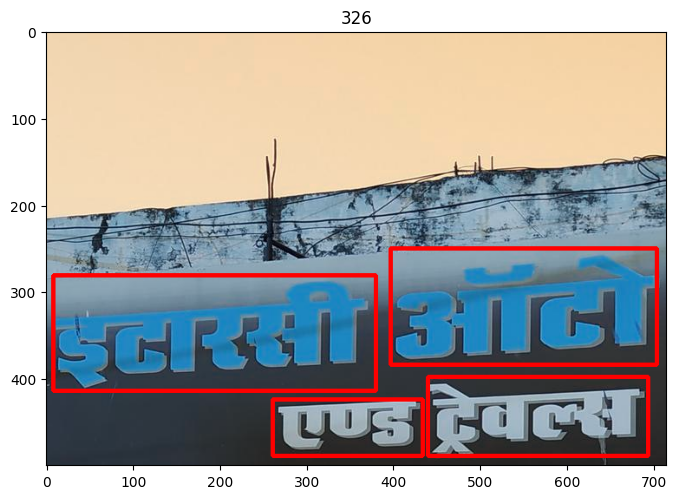

In [82]:
import random
i=random.randint(0,len(annotations))
plt.figure(figsize = (8,8))
# i = 150 # Random image location in data
img = cv2.imread(annotations.iloc[i,0])
box = annotations.iloc[i,5]
print(annotations.iloc[i,0],box)
img = plot_img(img,box)
plt.imshow(img)
plt.title(f"{i}")
plt.show()

In [83]:
%cd /content/drive/MyDrive/PROJECT_PADHAI/yolov5

/content/drive/MyDrive/PROJECT_PADHAI


In [84]:
# !cd /content/detection/real_Image_dataset_Detection/Annotation


In [85]:
!pwd

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


Folders arrangement inside base directory
base_dir:
    # images
        # train
        # validation
    # labels
        # train
        # validation

In [87]:
base_dir = '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data'
os.makedirs(base_dir,exist_ok=True)
images = os.path.join(base_dir, 'images')
os.makedirs(images, exist_ok=True)
labels = os.path.join(base_dir, 'labels')
os.makedirs(labels, exist_ok=True)
# Inside each folder we create seperate folders for each class
train = os.path.join(images, 'train')
os.makedirs(train, exist_ok=True)
validation = os.path.join(images, 'validation')
os.makedirs(validation, exist_ok=True)
train = os.path.join(labels, 'train')
os.makedirs(train, exist_ok=True)
validation = os.path.join(labels, 'validation')
os.makedirs(validation, exist_ok=True)


In [88]:
# os.chdir('/content')
# !pwd

In [89]:
# Splitting train and validation data
df_train, df_val = train_test_split(annotations, test_size=0.2, random_state=101)

print(df_train.shape)
print(df_val.shape)

(341, 9)
(86, 9)


In [90]:
yolo_data = []

In [91]:
!pwd

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


In [92]:
def process_data_for_yolo(df, data_type='train'):
    for _, row in tqdm(df.iterrows(), total=len(df)):

            image_name = os.path.basename(row['img_path'])

            xy_center = row['xy_center']
            image_width = row['img_width']
            image_height = row['img_height']
            box_width = row['width']
            box_height = row['height']

            yolo_data = []
            for (coord,box_width,box_height) in zip(xy_center,box_width,box_height):
                class_id = 0

                x_center = coord[0]/image_width
                y_center = coord[1]/image_height
                box_width = box_width/image_width
                box_height = box_height/image_height

                yolo_list = [class_id,x_center,y_center,box_width,box_height]
                yolo_data.append(yolo_list)
                #yolo_data = np.array(yolo_data)

                image_id = image_name.split('.')[0]
                np.savetxt(os.path.join('./data',
                        f"labels/{data_type}/{image_id}.txt"),
                        yolo_data,
                        fmt=["%d", "%f", "%f", "%f", "%f"]
                        ) # fmt means format the columns
            # Copy the image to images
            shutil.copyfile(row['img_path'],
            os.path.join('./data', f"images/{data_type}/{image_name}"))


In [93]:
%cd /content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection

/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection


In [94]:
process_data_for_yolo(df_train, data_type='train')
process_data_for_yolo(df_val, data_type='validation')

100%|██████████| 86/86 [00:05<00:00, 14.54it/s]


In [104]:
yaml_dict = {'train': '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/train',   # path to the train folder
            'val': '/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation', # path to the val folder
            'nc': 1,                             # number of classes
            'names': ['Hindi']}                # list of label names


In [106]:

import yaml

with open(r'/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/my_data.yaml', 'w') as file:
    documents = yaml.dump(yaml_dict, file)

In [107]:
%cd /content/drive/MyDrive/PROJECT_PADHAI

/content/drive/MyDrive/PROJECT_PADHAI


In [108]:
os.listdir('yolov5')

['.git',
 '.dockerignore',
 '.gitattributes',
 '.github',
 '.gitignore',
 'CITATION.cff',
 'CONTRIBUTING.md',
 'LICENSE',
 'README.md',
 'README.zh-CN.md',
 'benchmarks.py',
 'classify',
 'data',
 'detect.py',
 'export.py',
 'hubconf.py',
 'models',
 'pyproject.toml',
 'requirements.txt',
 'segment',
 'train.py',
 'tutorial.ipynb',
 'utils',
 'val.py']

In [109]:
%cd /content/drive/MyDrive/PROJECT_PADHAI/yolov5

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


In [110]:
!pwd

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


In [116]:
ls

benchmarks.py    data/       LICENSE       pyproject.toml    segment/        val.py
CITATION.cff     detect.py   models/       README.md         train.py
classify/        export.py   my_data.yaml  README.zh-CN.md   tutorial.ipynb
CONTRIBUTING.md  hubconf.py  __pycache__/  requirements.txt  utils/


# Training YOLOv5 model

In [112]:
!python train.py --help

2024-09-15 21:37:23.630477: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 21:37:23.663932: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 21:37:23.674111: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
usage: train.py [-h] [--weights WEIGHTS] [--cfg CFG] [--data DATA] [--hyp HYP] [--epochs EPOCHS]
                [--batch-size BATCH_SIZE] [--imgsz IMGSZ] [--rect] [--resume [RESUME]] [--nosave]
                [--noval] [--noautoanchor] [--noplots] [--evolve [EVOLVE]]
                [--evolve_population EVOLVE_POPULATION] [--resume_evolve RESUME_EVOLVE]
       

In [117]:
%cd /content/drive/MyDrive/PROJECT_PADHAI/yolov5

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


In [118]:
!pwd

/content/drive/MyDrive/PROJECT_PADHAI/yolov5


In [120]:
!WANDB_MODE="dryrun" python train.py --img 320 --batch 32 --epochs 60 --data my_data.yaml --weights yolov5s.pt

2024-09-15 21:47:04.810322: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 21:47:04.830121: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 21:47:04.835930: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=my_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=60, batch_size=32, imgsz=320, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data/hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, op

# Evaluation

In [121]:
df_val['img_path'].iloc[0]

'/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/real_Image_dataset_Detection/Image/118.jpg'

In [122]:
df_val['img_path'] = df_val['img_path'].str.replace('/real_Image_dataset_Detection/Image/','/data/images/validation/')

In [123]:
df_val.sample(n=4)['img_path']

,img_path
138,/content/drive/MyDrive/PROJECT_PADHAI/Computer...
252,/content/drive/MyDrive/PROJECT_PADHAI/Computer...
415,/content/drive/MyDrive/PROJECT_PADHAI/Computer...
206,/content/drive/MyDrive/PROJECT_PADHAI/Computer...


In [124]:
val_path=glob.glob('/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/*')
val_path[1]

'/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/309.jpg'

In [125]:
for i in range(4):
    !python detect.py --source "{val_path[i]}" --img-size 320 --conf 0.4 --weights "/content/drive/MyDrive/PROJECT_PADHAI/yolov5/runs/train/exp/weights/best.pt"


detect: weights=['/content/drive/MyDrive/PROJECT_PADHAI/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/118.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-366-gf7322921 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/118.jp

In [126]:
for path in df_val.sample(n=4)['img_path']:
    print(path)

/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/300.jpg
/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/149.jpg
/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/147. eef31413b9324b59a1645f6a683132091983543.jpg
/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/154.jpg


In [127]:
# Producing bounding box for random image from validation dataset
for path in df_val.sample(n=4)['img_path']:
    !python detect.py --source "{path}" --img-size 320 --conf 0.4 --weights "/content/drive/MyDrive/PROJECT_PADHAI/yolov5/runs/train/exp/weights/best.pt"


detect: weights=['/content/drive/MyDrive/PROJECT_PADHAI/yolov5/runs/train/exp/weights/best.pt'], source=/content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/data/images/validation/126. heritage-line-1_14_1495-1.jpg, data=data/coco128.yaml, imgsz=[320, 320], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-366-gf7322921 Python-3.10.12 torch-2.4.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/1 /content/drive/MyDrive/PROJECT_PADHAI/Computer_Vision/PADHAI_DL/PADHAI_DL/Text_Detection/da

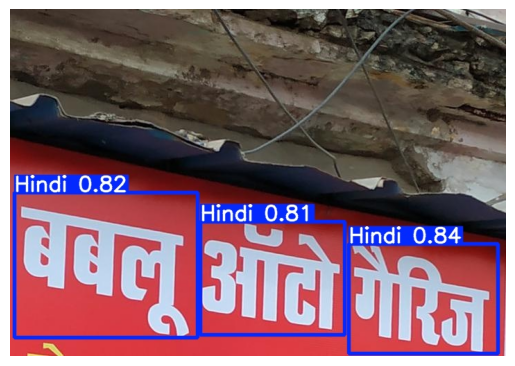

In [138]:
import cv2
import matplotlib.pyplot as plt

# Read the image using OpenCV
img = cv2.imread("/content/drive/MyDrive/PROJECT_PADHAI/yolov5/runs/detect/exp/118.jpg")

# Check if the image was loaded correctly
if img is not None:
    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.imshow(img_rgb)
    plt.axis('off')  # Optional: Turn off axis
    plt.show()
else:
    print("Error: Image not loaded correctly. Please check the file path.")
